## Import libraries & notebook configuration

In [6]:
import os
import pyxdf # xdf file importation
import matplotlib.pyplot as plt
import numpy as np
from my_functions import *
from my_filters import*
# library for creating filters
from scipy.signal import butter, iirnotch, filtfilt, welch
#%matplotlib widget

### Ensure that the root directory is the project directory
In some cases, the root directory may not be the project directory. This is usually the case when the notebook is run from a subdirectory of the project directory.

In [7]:
# if pwd is SRC  change to root
print("Current working directory: ", os.getcwd())
if os.path.basename(os.getcwd()) == "SRC":
    os.chdir("..")
print("Current working directory: ", os.getcwd())
print(os.path.basename(os.getcwd()))

Current working directory:  c:\Users\iWiss\Documents\GitHub\Stage_Signal_Physio
Current working directory:  c:\Users\iWiss\Documents\GitHub\Stage_Signal_Physio
Stage_Signal_Physio


In [8]:
plt.close("all")  # close all figure windows

## Initialization

### File selection and loading (REARM data)

In [9]:
# Define the file path (extracted via matlab from xdf file)
FILENAME = "001_MolLud_20201112_1_c_499.998Hz.csv"
# FILENAME="020_DesMar_20211129_1_c.xdf"
path = os.path.normpath("DAT/INPUT/"+FILENAME)
print(path)

DAT\INPUT\001_MolLud_20201112_1_c_499.998Hz.csv


In [10]:
EEG_data= np.genfromtxt(path, delimiter=',',skip_header=1)

EEG_raw_amplitudes=EEG_data[:,0:8] #first 8 columns are channels
EEG_times=EEG_data[:,8] #last is absolute time in sec

Srate=499
N=len(EEG_raw_amplitudes)

## Signal Preprocessing

#### Signal Centering

In [11]:
EEG_amplitudes_centered=EEG_raw_amplitudes-np.mean(EEG_raw_amplitudes,axis=0)

#### Rereferencing electrode to average

In [12]:
print(np.mean(EEG_amplitudes_centered))
EEG_amplitudes_rereferenced=EEG_amplitudes_centered-np.mean(EEG_amplitudes_centered)
print(EEG_amplitudes_rereferenced.shape)

-9.517775300082601e-13
(221938, 8)


#### Signal Filtering

In [13]:
def filter_signal(input_signal:np.array,sample_rate:int,order:int,cutofffreq:tuple):
    try:
        if len(cutofffreq)==3:
            LOW_CUTOFF_FREQ_THEORETICAL,HIGH_CUTOFF_FREQ_THEORETICAL,NOTCH_CUTOFF_FREQ=cutofffreq
        elif len(cutofffreq)==2:
            LOW_CUTOFF_FREQ_THEORETICAL,HIGH_CUTOFF_FREQ_THEORETICAL=cutofffreq
            NOTCH_CUTOFF_FREQ=None
        # cutoff frequency correction for filtfilt application
        LOW_CUTOFF_FREQ_CORRECTED = filtfilt_cutoff_frequency_corrector(
            order, LOW_CUTOFF_FREQ_THEORETICAL, sample_rate, pass_type="high_pass")

        HIGH_CUTOFF_FREQ_CORRECTED = filtfilt_cutoff_frequency_corrector(
            order, HIGH_CUTOFF_FREQ_THEORETICAL, sample_rate, pass_type="low_pass")

        print("LOW_CUTOFF_FREQ_THEORETICAL="+str(LOW_CUTOFF_FREQ_THEORETICAL) +
            ", HIGH_CUTOFF_FREQ_THEORETICAL="+str(HIGH_CUTOFF_FREQ_THEORETICAL))
        print("LOW_CUTOFF_FREQ_CORRECTED="+str(LOW_CUTOFF_FREQ_CORRECTED) +
            ", HIGH_CUTOFF_FREQ_CORRECTED="+str(HIGH_CUTOFF_FREQ_CORRECTED))

        # Filtering on all channels
        if NOTCH_CUTOFF_FREQ is not None:
            # 1-Notch-filter 50Hz [49,51] the centered-rereferenced signal
            input_signal, freqs_test_NOTCH, magnitudes_test_NOTCH = notch_filter(input_signal=input_signal,
                                                                                    sample_rate=sample_rate,
                                                                                    cutoff_freq=NOTCH_CUTOFF_FREQ,
                                                                                    stop_band_width=2)

        # 2-Then Band-pass filter the signal filtered by notch
        EEG_Filtered_NOTCH_BP, freq_test_BP, magnitude_test_BP = band_pass_filter(input_signal=input_signal,
                                                                                sample_rate=sample_rate,
                                                                                low_cutoff_freq=LOW_CUTOFF_FREQ_CORRECTED,
                                                                                high_cutoff_freq=HIGH_CUTOFF_FREQ_CORRECTED,
                                                                                filter_order=order)
        print("Filtered signal shape:",np.shape(EEG_Filtered_NOTCH_BP))
    except UnboundLocalError :
        print(f"Specified cutofffreq={cutofffreq} - The tuple must contain only 2 or 3 elements as (low_cutoff_freq,high_cutoff_freq,notch_cutoff_freq)")
    return EEG_Filtered_NOTCH_BP, freq_test_BP, magnitude_test_BP

In [14]:
print(np.shape(EEG_amplitudes_rereferenced))
EEG_amplitudes_centered_filtered,_,_=filter_signal(input_signal=EEG_amplitudes_rereferenced,
                                               sample_rate=Srate,
                                               order=8,cutofffreq=(5,100,50))


(221938, 8)
LOW_CUTOFF_FREQ_THEORETICAL=5, HIGH_CUTOFF_FREQ_THEORETICAL=100
LOW_CUTOFF_FREQ_CORRECTED=4.732, HIGH_CUTOFF_FREQ_CORRECTED=104.198
Filtered signal shape: (221938, 8)


## PSD estimation results : Electrode C3 and C4 

### Electrode selection

In [15]:
# definition of the EEG channels' names
channels_dict = {"Channel_1": "C4",
                "Channel_2": "FC2",
                "Channel_3": "FC6",
                "Channel_4": "CP2",
                "Channel_5": "C3",
                "Channel_6": "FC1",
                "Channel_7": "FC5",
                "Channel_8": "CP1"}

In [16]:
# Selection of one electrode
ELECTRODE_NUMBER1 = 5  # [1,8] #C3
ELECTRODE_INDEX1 = ELECTRODE_NUMBER1-1  # python indices start a 0

ELECTRODE_NUMBER2 = 1  # [1,8] #C4
ELECTRODE_INDEX2 = ELECTRODE_NUMBER2-1  # python indices start a 0

print("electrode",str(ELECTRODE_NUMBER1),"shape:",EEG_raw_amplitudes[:,ELECTRODE_INDEX1].shape)

electrode 5 shape: (221938,)


In [17]:
#Results to show
RAW_BUTTON=False
CENTERED_BUTTON=False
FILTERED_BUTTON=True

### Raw signal

In [18]:
print(EEG_raw_amplitudes.shape)
if RAW_BUTTON:
    plot_signal_time_dsps(fig_number=1,signal=EEG_raw_amplitudes[:,ELECTRODE_INDEX1],sample_rate=Srate,signal_name=FILENAME+"\n Raw signal Electrode "+channels_dict["Channel_"+str(ELECTRODE_NUMBER1)])
    plot_signal_time_dsps(fig_number=2,signal=EEG_raw_amplitudes[:,ELECTRODE_INDEX2],sample_rate=Srate,signal_name=FILENAME+"\n Raw signal Electrode "+channels_dict["Channel_"+str(ELECTRODE_NUMBER2)])

(221938, 8)


### Centered signal


In [19]:
print(EEG_amplitudes_centered.shape)

if CENTERED_BUTTON:
    print(EEG_raw_amplitudes.shape)
    plot_signal_time_dsps(fig_number=1,signal=EEG_amplitudes_centered[:,ELECTRODE_INDEX1],sample_rate=Srate,
                        signal_name=FILENAME+"\n Centered signal Electrode "+channels_dict["Channel_"+str(ELECTRODE_NUMBER1)])
    plot_signal_time_dsps(fig_number=2,signal=EEG_amplitudes_centered[:,ELECTRODE_INDEX2],sample_rate=Srate,
                        signal_name=FILENAME+"\n Centered signal Electrode "+channels_dict["Channel_"+str(ELECTRODE_NUMBER2)])

(221938, 8)


### Filtered signal

(221938, 8)
N:  221938
duration:  444.76553106212424
time_vector shape:  (221938,)
N:  221938
duration:  444.76553106212424
time_vector shape:  (221938,)


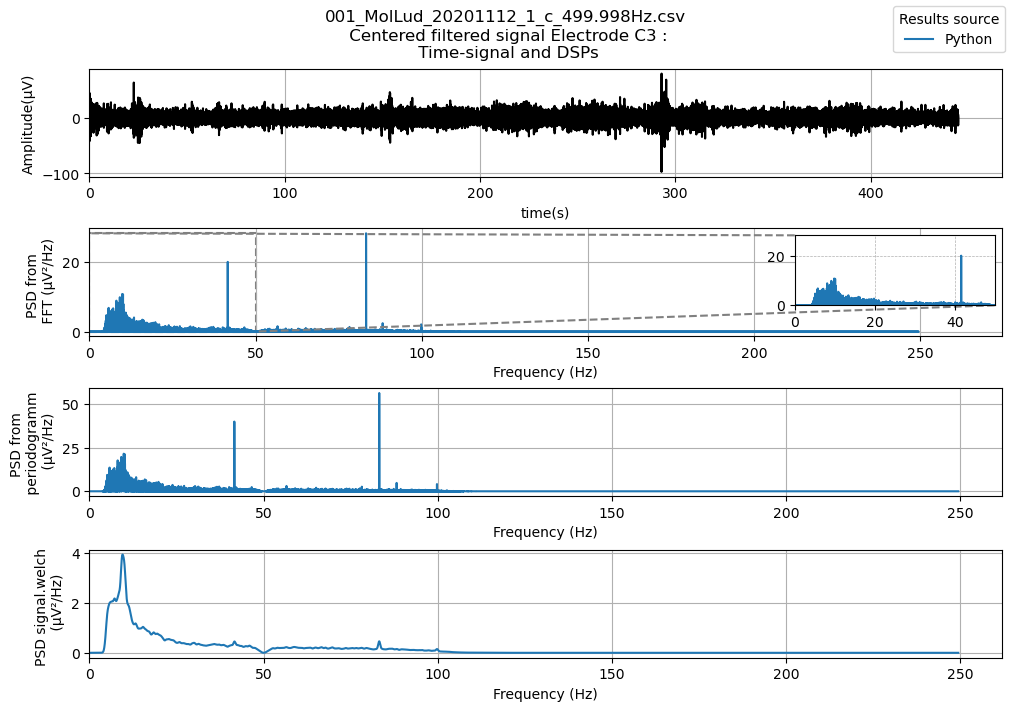

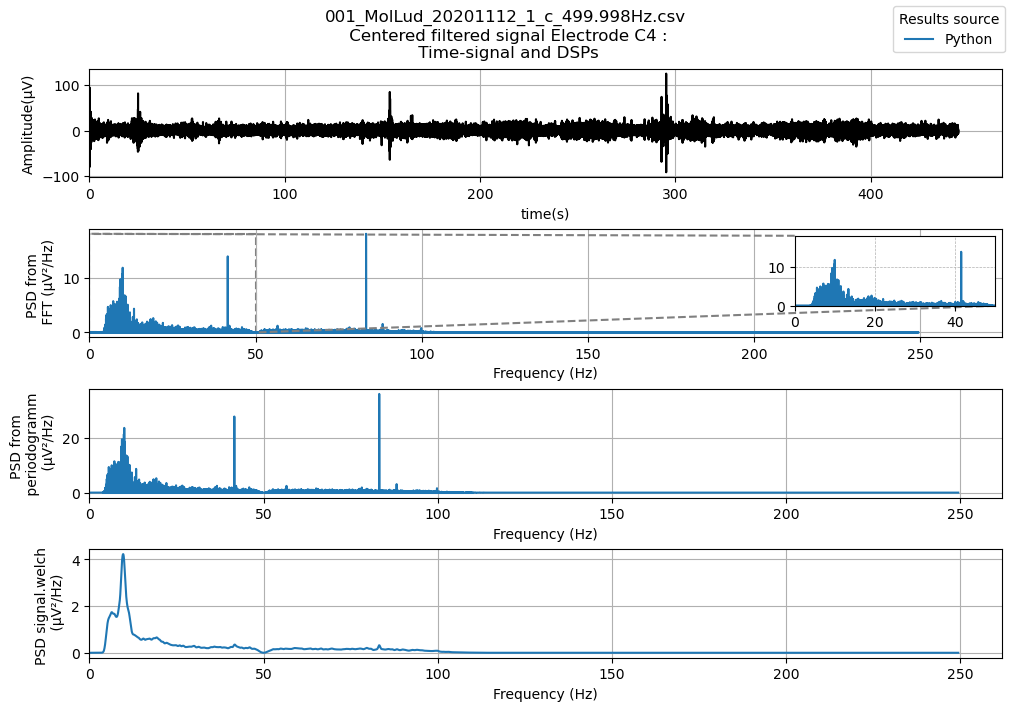

In [20]:
print(EEG_amplitudes_centered_filtered.shape)
if FILTERED_BUTTON:
    plot_signal_time_dsps(fig_number=1,signal=EEG_amplitudes_centered_filtered[:,ELECTRODE_INDEX1],sample_rate=Srate,
                        signal_name=FILENAME+"\n Centered filtered signal Electrode "+channels_dict["Channel_"+str(ELECTRODE_NUMBER1)])
    plot_signal_time_dsps(fig_number=2,signal=EEG_amplitudes_centered_filtered[:,ELECTRODE_INDEX2],sample_rate=Srate,
                        signal_name=FILENAME+"\n Centered filtered signal Electrode "+channels_dict["Channel_"+str(ELECTRODE_NUMBER2)])